In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from collections import namedtuple
import numpy as np
import matplotlib
from itertools import count
import random
import math
from copy import deepcopy
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [12]:
replay = namedtuple('replay',('state','action','reward','next_state'))

class Replay_buffer():
    
    def __init__(self , buffer_size):
        self.buffer_size = buffer_size
        self.buffer = np.zeros(  [buffer_size] , dtype = replay)
        self.index = 0
        self.cur_size = 0
        
    def push(self,experience):
        self.buffer[self.index] = experience
        self.index = (self.index+1)%self.buffer_size
        if self.cur_size < self.buffer_size:
            self.cur_size += 1
    def sample(self,batch_size):
        sample_index = np.random.choice(np.arange(self.cur_size),size=batch_size,replace=False)
        return self.buffer[sample_index]

    
class DQN(nn.Module): #Shallow QN
    
    def __init__(self):
        super(DQN,self).__init__()
        self.L1 = nn.Linear(2,128)
        self.L2 = nn.Linear(128,64)
        self.out = nn.Linear(64,3)
    
    def forward(self,x):
        x = F.tanh(self.L1(x))
        x = F.tanh(self.L2(x))
        x = self.out(x)
        return x

In [13]:
num_epsoide = 3000 # 預設 4000

network = DQN()
target_network = DQN()
target_network.load_state_dict(network.state_dict())
loss_fn = torch.nn.MSELoss(size_average=True)
buffer = Replay_buffer(15000)
EPS_START = 0.999
EPS_END = 0.1
EPS_DECAY = 50000
steps_done = 0
batch_size = 100 # 預設為64，改成100稍微快一點，但效能應該會降低一點
use_cuda = torch.cuda.is_available() 
optimizer = torch.optim.RMSprop(network.parameters())


if use_cuda:
    network = network.cuda()
    target_network = target_network.cuda()
    
env = gym.make('MountainCar-v0').unwrapped
reward_history = []
max_position = -2.0
try:
    for e in range(num_epsoide):
        state = env.reset()
        state = torch.tensor(state).float()
        DONE = False
        acc_reward = 0
        for time_step in count():
            if DONE:
                break
            if e % 100 == 0:
                print('training...')
#                 env.render() # 這行是用來顯示訓練畫面的，但是很吃資源，我一開就會當機......
            eps_threshold = EPS_END + \
            (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

            if use_cuda:
                state = state.cuda()
            
            if random.random() >= eps_threshold:
                action = torch.argmax(network(state))
            else:
                action = torch.tensor(env.action_space.sample(),dtype=torch.long)
                
                
            next_state , reward , done , _ = env.step(action.item())
            steps_done += 1
            
            # 調整下一行的 c 以及 k 就能試出很多種變化了
            reward += abs(next_state[0] + 0.9) + next_state[1] * 11  #hint: abs(next_state[0]+c) + next_state[1]*k
            acc_reward += reward
            
            next_state = torch.tensor(next_state).float()
            
            if done == True or time_step >= 200:
                if next_state[0] >= 0.5:
                    reward = 100.0 
                    print('------------done-----------')
                DONE = True
                next_state = None
                
            
            experience = replay(state , torch.tensor([action]).long(), \
                                torch.tensor([reward]) , next_state)
            buffer.push(experience)
            
            state = next_state
        
            
        
            if buffer.cur_size >= batch_size:

                batch = buffer.sample(batch_size=batch_size)
                batch = replay(*zip(*batch))

                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), dtype=torch.uint8)

                non_final_next_state = torch.cat([s for\
                                                  s in batch.next_state if s is not None]).view(-1,2)
                
                state_batch = torch.cat(batch.state).view(-1,2)
                reward_batch = torch.cat(batch.reward)
                action_batch = torch.cat(batch.action).view(-1,1)
                if use_cuda:
                    state_batch = state_batch.cuda()
                    reward_batch = reward_batch.cuda()
                    action_batch = action_batch.cuda()
                    non_final_next_state = non_final_next_state.cuda()
                    non_final_mask = non_final_mask.cuda()
                next_state_values = torch.zeros(batch_size)
                if use_cuda:
                    next_state_values = next_state_values.cuda()
                next_state_values[non_final_mask] = target_network(non_final_next_state).max(1)[0]
                expected_state_values = next_state_values + reward_batch.view(-1)
                expected_state_values = expected_state_values
                state_action_value = network(state_batch).gather(1,action_batch).view(-1)
                expected_state_values = expected_state_values.detach()
                
                    
                
                loss = loss_fn(state_action_value,expected_state_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if e %30 == 0:
                    target_network.load_state_dict(network.state_dict())
        reward_history.append(acc_reward)
        print(eps_threshold)
finally:
    env.close()

training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
trai

([<matplotlib.lines.Line2D at 0x19d290d7f98>], 3000)

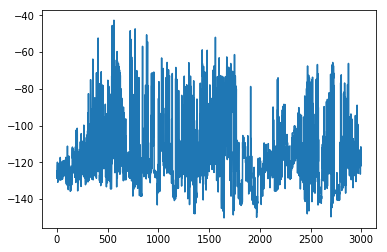

In [14]:
import matplotlib.pyplot as plt
plt.plot(reward_history),len(reward_history)

In [15]:
from PIL import Image
try:
    env = gym.make('MountainCar-v0').unwrapped
    frames = []
    DONE = False
    state = env.reset()
    state = torch.tensor(state).float()
    if use_cuda:
        state = torch.tensor(state).float()
    for t in count():
        env.render(mode='rgb_array')
        frames.append(Image.fromarray(env.render(mode='rgb_array')))
        if use_cuda:
            state = state.cuda()
        action = torch.argmax(network(state))
        print(action)
        next_state , reward , done , _ = env.step(action.item())
        
        state = torch.tensor(next_state).float()
        if use_cuda:
            state = state.cuda()
        if t >= 200:
            print('done')
            break
finally:
    env.close()
    with open('MountainCar-v0.gif','wb') as f:
        im = Image.new('RGB', frames[0].size)
        im.save(f, save_all=True, append_images=frames)


C:\Users\shawn\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
t